In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from string import punctuation
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Embedding, Dropout,BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('all-data.csv', delimiter=',', encoding='latin-1', names=['sentiment', 'text'])
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
class_distribution = df['sentiment'].value_counts(normalize=True)
class_distribution

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64

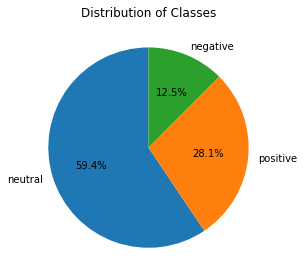

In [ ]:
labels = class_distribution.index
values = class_distribution.values
plt.pie(values, labels=labels, startangle=90, autopct='%1.1f%%')
plt.title('Distribution of Classes')
plt.tight_layout()
plt.show()

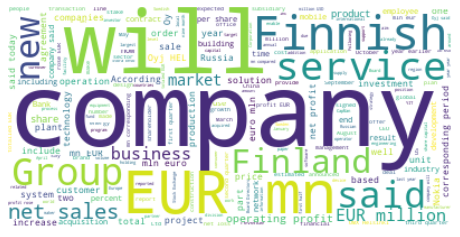

In [ ]:
text = " ".join([x for x in df.text])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Data preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Remove punctuation


In [ ]:
def rem_punc(t):
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''

    # remove punctuation from the string
    for c in punctuations:
        t=t.replace(c,' ')

    # display the unpunctuated string
    return t.replace('\n',' ')

df['punct'] = df['text'].apply(lambda x: rem_punc(x))

Lowercase

In [ ]:
df['lowercase'] = df['punct'].apply(lambda x: x.lower())

Tokenization

In [ ]:
df['tokenized'] = df['lowercase'].apply(lambda x: word_tokenize(x))

Remove stopwords

In [ ]:
sw = stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in sw]
    return text
df['nonsw'] = df['tokenized'].apply(lambda x: remove_stopwords(x))

Lemmatization

In [ ]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(t):
    nltk_tagged = nltk.pos_tag(t)
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemma = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemma.append(word)
        else:        
            lemma.append(lemmatizer.lemmatize(word, tag))
    return lemma

df['lemmed'] = df['nonsw'].apply(lambda x: lemmatize_sentence(x))

In [ ]:
df.head()

,sentiment,text,punct,lowercase,tokenized,nonsw,lemmed
0,neutral,"According to Gran , the company has no plans t...",According to Gran the company has no plans t...,according to gran the company has no plans t...,"[according, to, gran, the, company, has, no, p...","[according, gran, company, plans, move, produc...","[accord, gran, company, plan, move, production..."
1,neutral,Technopolis plans to develop in stages an area...,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...","[technopolis, plans, develop, stages, area, le...","[technopolis, plan, develop, stage, area, less..."
2,negative,The international electronic industry company ...,The international electronic industry company ...,the international electronic industry company ...,"[the, international, electronic, industry, com...","[international, electronic, industry, company,...","[international, electronic, industry, company,..."
3,positive,With the new production plant the company woul...,With the new production plant the company woul...,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa...","[new, production, plant, company, would, incre...","[new, production, plant, company, would, incre..."
4,positive,According to the company 's updated strategy f...,According to the company s updated strategy f...,according to the company s updated strategy f...,"[according, to, the, company, s, updated, stra...","[according, company, updated, strategy, years,...","[accord, company, update, strategy, year, basw..."


In [ ]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 


##Word embeddings Doc2vec


In [ ]:
data=pd.DataFrame({'text': df['lemmed'], 'sentiment': df['sentiment']})

In [ ]:
data_tagged = data.apply(lambda r: TaggedDocument(words=r['text'], tags=[r.sentiment]), axis=1)

In [ ]:
data_tagged.values

array([TaggedDocument(words=['accord', 'gran', 'company', 'plan', 'move', 'production', 'russia', 'although', 'company', 'grow'], tags=[1]),
       TaggedDocument(words=['technopolis', 'plan', 'develop', 'stage', 'area', 'less', 'square', 'meter', 'order', 'host', 'company', 'work', 'computer', 'technology', 'telecommunications', 'statement', 'say'], tags=[1]),
       TaggedDocument(words=['international', 'electronic', 'industry', 'company', 'elcoteq', 'laid', 'ten', 'employee', 'tallinn', 'facility', 'contrary', 'earlier', 'layoff', 'company', 'contract', 'rank', 'office', 'worker', 'daily', 'postimees', 'report'], tags=[2]),
       ...,
       TaggedDocument(words=['operating', 'profit', 'fell', 'eur', 'mn', 'eur', 'mn', 'include', 'vessel', 'sale', 'gain', 'eur', 'mn'], tags=[2]),
       TaggedDocument(words=['net', 'sale', 'paper', 'segment', 'decrease', 'eur', 'mn', 'second', 'quarter', 'eur', 'mn', 'second', 'quarter', 'operate', 'profit', 'exclude', 'non', 'recur', 'item', 'ris

In [ ]:
X=data.text
Y=data.sentiment

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
encoded_docs = tokenizer.texts_to_sequences(X)
max_length = max([len(s) for s in X])
x = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

y = to_categorical(Y) # one hot encoding

In [ ]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in data_tagged.values])


/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in data_tagged.values]), total_examples=len(data_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

In [ ]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
          embedding_matrix[i]=vec


In [ ]:
d2v_model.wv.most_similar(positive="business")

[('edible', 0.7561734914779663),
 ('rigid', 0.7437518835067749),
 ('marubeni', 0.7139172554016113),
 ('middle', 0.6936863660812378),
 ('maruy', 0.6858460903167725),
 ('dartford', 0.6844229698181152),
 ('smarket', 0.6821991205215454),
 ('sandberg', 0.6821551322937012),
 ('adr', 0.6820173263549805),
 ('streamline', 0.6808281540870667)]

In [ ]:
# splitting data
x_train,x_test,y_train,y_test = train_test_split(x, y, stratify=y, test_size = 0.2 , random_state = 0)

## CNN

In [ ]:
model = Sequential()
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=x.shape[1],weights=[embedding_matrix],trainable=True))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 20)            150560    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 128)           12928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6915      
Total params: 170,403
Trainable params: 170,403
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=1,
    verbose=1)


callbacks = [ reduce_lr, early_stopping]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, callbacks=callbacks)

Epoch 1/50
122/122 - 2s - loss: 0.6812 - accuracy: 0.5911
Epoch 2/50
122/122 - 1s - loss: 0.6594 - accuracy: 0.5942
Epoch 3/50
122/122 - 1s - loss: 0.6410 - accuracy: 0.5942
Epoch 4/50
122/122 - 1s - loss: 0.6255 - accuracy: 0.5942
Epoch 5/50
122/122 - 1s - loss: 0.6127 - accuracy: 0.5942
Epoch 6/50
122/122 - 1s - loss: 0.6019 - accuracy: 0.5942
Epoch 7/50
122/122 - 1s - loss: 0.5929 - accuracy: 0.5942
Epoch 8/50
122/122 - 1s - loss: 0.5855 - accuracy: 0.5942
Epoch 9/50
122/122 - 1s - loss: 0.5793 - accuracy: 0.5942
Epoch 10/50
122/122 - 1s - loss: 0.5740 - accuracy: 0.5942
Epoch 11/50
122/122 - 1s - loss: 0.5698 - accuracy: 0.5942
Epoch 12/50
122/122 - 1s - loss: 0.5661 - accuracy: 0.5942
Epoch 13/50
122/122 - 1s - loss: 0.5631 - accuracy: 0.5942
Epoch 14/50
122/122 - 1s - loss: 0.5605 - accuracy: 0.5942
Epoch 15/50
122/122 - 1s - loss: 0.5584 - accuracy: 0.5942
Epoch 16/50
122/122 - 1s - loss: 0.5566 - accuracy: 0.5942
Epoch 17/50
122/122 - 1s - loss: 0.5551 - accuracy: 0.5942
Epoch 

In [ ]:
y_predict=model.predict(x_test)
y_predict=np.argmax(y_predict, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       273
           1       0.59      1.00      0.75       576
           2       0.00      0.00      0.00       121

    accuracy                           0.59       970
   macro avg       0.20      0.33      0.25       970
weighted avg       0.35      0.59      0.44       970



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LSTM

In [ ]:
# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=x.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 20)            150560    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                14200     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 164,913
Trainable params: 164,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(x_train, y_train, epochs =50, batch_size=32, verbose = 2)

Epoch 1/50
122/122 - 5s - loss: 0.5632 - acc: 0.5921
Epoch 2/50
122/122 - 3s - loss: 0.4521 - acc: 0.6723
Epoch 3/50
122/122 - 3s - loss: 0.3344 - acc: 0.7776
Epoch 4/50
122/122 - 3s - loss: 0.2858 - acc: 0.8096
Epoch 5/50
122/122 - 3s - loss: 0.2596 - acc: 0.8313
Epoch 6/50
122/122 - 3s - loss: 0.2386 - acc: 0.8416
Epoch 7/50
122/122 - 3s - loss: 0.2309 - acc: 0.8475
Epoch 8/50
122/122 - 3s - loss: 0.2195 - acc: 0.8537
Epoch 9/50
122/122 - 3s - loss: 0.2171 - acc: 0.8566
Epoch 10/50
122/122 - 3s - loss: 0.2089 - acc: 0.8617
Epoch 11/50
122/122 - 3s - loss: 0.1905 - acc: 0.8751
Epoch 12/50
122/122 - 3s - loss: 0.1581 - acc: 0.9203
Epoch 13/50
122/122 - 3s - loss: 0.1649 - acc: 0.9254
Epoch 14/50
122/122 - 3s - loss: 0.1052 - acc: 0.9551
Epoch 15/50
122/122 - 3s - loss: 0.0945 - acc: 0.9567
Epoch 16/50
122/122 - 3s - loss: 0.0900 - acc: 0.9579
Epoch 17/50
122/122 - 3s - loss: 0.0659 - acc: 0.9711
Epoch 18/50
122/122 - 3s - loss: 0.0567 - acc: 0.9786
Epoch 19/50
122/122 - 3s - loss: 0.05

In [ ]:
y_predict=model.predict(x_test)
y_predict=np.argmax(y_predict, axis=1)
#y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.60      0.55      0.57       273
           1       0.78      0.81      0.79       576
           2       0.53      0.54      0.53       121

    accuracy                           0.70       970
   macro avg       0.64      0.63      0.63       970
weighted avg       0.70      0.70      0.70       970

